# TM10007 Assignment template

In [275]:
# Run this to use from colab environment
# %pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

In [276]:
# %pip install -U scikit-learn
# %pip install mlxtend

# Extentions used in assignment

In [277]:
# Installing all the extentions used in this assignment.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from worcliver.load_data import load_data, load_Ft_set, load_D_set, second_split, load_Tr_set, load_Va_set

from scipy.stats import randint
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Functions used in assignment
There are multiple functions used for this assignment. Every function is explained in the module of the function itself.

In [278]:
def return_X_y(df):
    '''
    Returns dataframe y_d including the labels, and a seperate dataframe X_d including the feature information.
    '''
    y_d = df.pop('label').to_frame()
    X_d = df
    # making y_d binairy
    le = LabelEncoder()
    y_d_bin = le.fit_transform(y_d.to_numpy().reshape(-1,))

    return X_d, y_d, y_d_bin


def preprocessing(feature_df):
    '''
    This function preprocesses the features by removing zero-variance and zero-filled features from the dataset.
    '''

    # Remove zero-variance features
    filter = VarianceThreshold(threshold=0.0)
    df_filter1 = filter.fit_transform(feature_df)
    features_kept = filter.get_support()
    names = feature_df.columns[features_kept]
    df_filter2 = pd.DataFrame(df_filter1, columns=names)
    zero_var = pd.DataFrame(feature_df.columns[~features_kept], columns=["removed_features"])
    zero_var_removed = feature_df.columns[~features_kept].tolist()

    # Remove zero-filled features (if >80% is zero)
    zero_percents = (df_filter2 == 0).sum() / len(df_filter2) * 100
    threshold = 80
    nonzero_cols = df_filter2.columns[zero_percents <= threshold]
    zero_cols = df_filter2.columns[zero_percents > threshold]
    df_filtered = pd.DataFrame(df_filter2, columns=nonzero_cols)
    high_zero_frac_removed = zero_cols.tolist()

    print(f"Number of removed columns due to zero-variance: {len(zero_var)}")
    print(f"Number of removed non-zero-variance columns due to fraction zero > 80%: {len(zero_cols)}")
    print(f'Remaining number of features after preprocessing: {df_filtered.shape[1]}')

    removed_features = zero_var_removed + high_zero_frac_removed

    return df_filtered, removed_features


def outliers(X_filtered):
    ''' 
    This fuction shifts the outliers in the feature space to the boundries of the distributed data. The chosen boundries 
    are 3 times the standard deviation away from the mean of the features.
    '''
    means = X_filtered.mean()
    stds = X_filtered.std()
    threshold = 3

    for feature in X_filtered.columns:
        # Calculate the lower and upper bounds for the feature
        lower_bound = means[feature] - (stds[feature] * threshold)
        upper_bound = means[feature] + (stds[feature] * threshold)

        # Shift outliers with upper and lower bound
        X_filtered.loc[X_filtered[feature] < lower_bound, feature] = lower_bound
        X_filtered.loc[X_filtered[feature] > upper_bound, feature] = upper_bound
    
    return X_filtered


def standard_scaling(column):
    '''
    This function will return the scaled features with standard scaling. Giving the features mean of 0 and a standard deviation of 1. 
    To use the standard scaling, assumed is that the data has a normal distribution. To apply this to a dataframe
    this function needs to be applied to each column (which can be done with the use of .apply())
    '''
    feat2 = column.to_numpy()
    standard_scale = StandardScaler()
    feat_scaled2 = standard_scale.fit_transform(feat2.reshape(-1, 1))
    return pd.Series(feat_scaled2.flatten(), index=column.index)


def plt_tsne(df_features, labels):
    '''
    Using this function will return a 2 dimensional t-SNE plot.
    May be used as visualisation and possible feature extraction.
    '''

    labels = labels['label'].replace({'benign': 0, 'malignant': 1})
    labels = labels.to_numpy()
    df_features = df_features.to_numpy()

    # Perform TSNE
    tsne = TSNE(n_components=2, learning_rate="auto", perplexity=5)
    X_tsne = tsne.fit_transform(df_features, labels)

    # Plot the t-SNE representation colored by the labels
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels)
    return plt.show()


def plt_lda(df_features, labels):
    '''
    Using this function will return a 1 dimensional LDA plot. May be used as feature extraction.
    '''

    labels = labels['label'].replace({'benign': 0, 'malignant': 1})
    labels = labels.to_numpy()
    df_features = df_features.to_numpy()

    # Perform LDA
    lda = LDA()
    X_lda = lda.fit_transform(df_features, labels)

    # Plot the LDA representation colored by the labels
    plt.scatter(X_lda, np.zeros_like(X_lda), c=labels)
    plt.xlabel('LD1')
    plt.ylim(-0.1, 0.1)

    return plt.show()

def feature_selection(X_norm, y_d):
    ''' 
    This function selects 120 features from all the features because the ROC curves showed that
    using 120 features is good for all three classfiers, furthermore it is close to 1/4th of the features
    from the dataset. After the selection there are less features than samples. The noisy features are removed.
    The feature selection is done bij RFE, which is to select features by recursively considering smaller and smaller sets of features.
    '''

    model = LogisticRegression(max_iter=1000)  # the iterations is set to 1000 that is more than enough, it will run longer if the iterations are higer
    rfe = RFE(estimator=model, n_features_to_select=120)
    rfe.fit(X_norm, y_d.to_numpy().reshape(-1,))
    final_features = X_norm.columns[rfe.support_]
    final_X_norm = X_norm.loc[:, final_features]
    
    return final_X_norm, final_features


def PCA_variance(X, selected_features):
    '''
    This function will calculate the variance of the PCA components
    '''
    covar_matrix = PCA(n_components=len(selected_features))
    covar_matrix.fit(X)

    variance = covar_matrix.explained_variance_ratio_
    var = np.cumsum(np.round(variance, decimals=3)*100)

    return variance, var


def PCA_amount_features(var):
    '''
    This function will perform cumulative variance curve of the PCA. On the x-axis the amount of features is 
    shown and on the y-axis the percentage of the variance is given. As cut-off is a minimum cumulative variance of 90% chosen,
    this is a conservative approach. The amount of features nessesary for the PCA curve is returned. 
    '''
    # Plotting the commulative variance curve
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Variance Explained')
    plt.ylim(min(var), 100.5)
    plt.style.context('seaborn-whitegrid')
    plt.axhline(y=90, color='r', linestyle='--')
    plt.plot(var)
    plt.show()

    # The amount of features calculated that is needed in the PCA.
    for j, val in enumerate(var):
        if val > 90:  # commulatieve variance curve cut off of at 90%
            print("The index of the first number that is bigger than 90% is:", j)
            n_comp = j+1
            break
        
    return n_comp


def PCA_transform(X_scaled_selected, n_comp):
    '''
    This function will perform the PCA transform with the amount of features calculated in the function PCA_amount_features.
    '''
    pca = PCA(n_components=n_comp)  # as index starts at 0 the number of components is one higher
    X_pca = pca.fit_transform(X_scaled_selected)

    variance = pca.explained_variance_ratio_
    var = np.cumsum(np.round(variance, decimals=3)*100)

    return pca, X_pca, variance, var


def PCA_transform_overview(variance, var):
    '''
    This function will compute a overview of the features combined in the PCA with there explained variance and comulative variance.
    '''
    n_components = len(variance)
    idx = np.arange(n_components)+1

    df_explained_variance = pd.DataFrame([variance, var],
                                        index=['explained variance', 'cumulative [%]'],
                                        columns=idx).T

    mean_explained_variance = df_explained_variance.iloc[:, 0].mean()  # calculate mean explained variance

    # DISPLAY info about PCA
    print('PCA Overview')
    print('='*40)
    print("Total: {} components".format(n_components))
    print('-'*40)
    print('Mean explained variance:', round(mean_explained_variance, 3))
    print('-'*40)
    print(df_explained_variance)
    print('-'*40)

    return df_explained_variance, mean_explained_variance, idx


def scree_plot(df_explained_variance, mean_explained_variance, idx):
    '''
    The explained variance and the mean from the explaned variance with its indexes calculated in the function 
    PCA_transform_overview are used to make a scree plot to make the variances of the different features more visual.
    '''
    limit_df = 15  # change this number if you want to have more or less PCA components visualized
    df_explained_variance_limited = df_explained_variance.iloc[:limit_df, :]

    # make scree plot
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax1.set_title('Explained variance across principal components', fontsize=14)
    ax1.set_xlabel('Principal component', fontsize=12)
    ax1.set_ylabel('Explained variance', fontsize=12)

    ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
    ax2 = ax1.twinx()
    ax2.grid(False)

    ax2.set_ylabel('Cumulative', fontsize=14)
    ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative [%]', data=df_explained_variance_limited, color='#fc8d59')

    ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59')  # plot mean
    ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average",
             color='#fc8d59', fontsize=14)  # label y axis

    max_y1 = max(df_explained_variance_limited.iloc[:, 0])
    max_y2 = max(df_explained_variance_limited.iloc[:, 1])
    ax1.set(ylim=(0, max_y1+max_y1*.1))
    ax2.set(ylim=(0, max_y2+max_y2*.1))

    return plt.show()


def factor_loadings(X, pca, df_explained_variance):
    # DEFINE PARAMETERS
    selected_features = X.columns
    top_k = 3

    # PCA factor loadings
    df_c = pd.DataFrame(pca.components_, columns=selected_features).T

    print("Factor Loadings for the 1. component \n(explains {0:.2f} of the variance)"
          .format(df_explained_variance.iloc[0, 0]))
    print('='*40, '\n')
    print('Top {} highest'.format(top_k))
    print('-'*40)
    print(df_c.iloc[:, 0].sort_values(ascending=False)[:top_k], '\n')

    print('Top {} lowest'.format(top_k))
    print('-'*40)
    print(df_c.iloc[:, 0].sort_values()[:top_k])

    # Plot heatmap
    size_yaxis = round(X[selected_features].shape[1] * 0.5)

    fig, ax = plt.subplots(figsize=(8, size_yaxis))
    sns.heatmap(df_c.iloc[:, :], annot=True, cmap="YlGnBu", ax=ax)

    return plt.show()


def classifiers(clsfs, X_pca, y_train):
    f1_scores = []
    # Loop over each classifier and fit the model, make predictions and compute metrics
    for clf in clsfs:
        clf.fit(X_pca, y_train)
        y_pred = clf.predict(X_pca)
        accuracy = metrics.accuracy_score(y_train, y_pred)
        F1 = metrics.f1_score(y_train, y_pred)
        f1_scores.append(F1)
        precision = metrics.precision_score(y_train, y_pred)
        recall = metrics.recall_score(y_train, y_pred)
        print(type(clf).__name__)
        print('Accuracy:', accuracy)
        print('F1:', F1)
        print('Precision:', precision)
        print('Recall:', recall)
        print()

    return f1_scores

## Data loading and cleaning

Assignment explanation: Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

This assignment is to create a classifier to differentiate between benign and malignant primary solid liver tumors in non-cirrhotic livers.

In [279]:
# Data loading functions. Uncomment the one you want to use

df = load_data()

# Data clean-up (before splitting data)
In this section double entries, such as repeated features and samples, will be removed from the dataset. In the section below the dataset is checkt on NaN values, this is crucial for handling missing data. The amount of numeric features is counted, which is essential for selecting the appropriate classifier.

In [280]:
'''
These 2 lines add a duplicate sample in the DataFrame, you can than observe what the effect is 
in the printed sentence. If you'd like to see it indeed works, please uncomment these lines.
'''
# row = df.iloc[0].copy()
# df = df.append(row, ignore_index=True)
'''
In the lines below we first drop all duplicate entries, whether it is a duplicate row or a column. 
Additionally, the number of duplicates will be returned to the user.
'''

df_f = df.drop_duplicates()
print(f'The number of samples (after removal of duplicates): {len(df_f.index)}, the number of duplicates that had to be removed: {len(df.index)-len(df_f.index)}')
print(f'The number of columns (after removal of duplicates): {len(df_f.columns)}, the number of duplicates that had to be removed: {len(df.columns)-len(df_f.columns)}')

The number of samples (after removal of duplicates): 186, the number of duplicates that had to be removed: 0
The number of columns (after removal of duplicates): 494, the number of duplicates that had to be removed: 0


In [281]:
df = df_f
df = df.replace('', np.nan)  # any empty values are replaced for NaN
# print(df.describe(include='all'))  # uncomment if interested

check_for_nan = df.isnull().values.any()  # checking whether the dataset contains NaN values
print(f'Are there NaN existing in the resting dataset?: {check_for_nan}')

non_numeric_columns = df.select_dtypes(exclude='number').columns.tolist()  # label is a non_numeric_column
numeric_columns = df.select_dtypes(include='number').columns.tolist()
print(f'amount of numeric features = {len(numeric_columns)}')  # all features are numeric_columns

Are there NaN existing in the resting dataset?: False
amount of numeric features = 493


### Conclusion
The table above shows there are only 2 labels present in the dataset, from observation of the csv.file we can see the labels are 'malignant' and 'benign'. What is also stated here, that 94 of the 186 samples was labeled malignant (and thus 92 samples are labeled benigne). This information is usefull in the next step, to determine whether a stratified splitting of our data, would be necessary.

# Data splitting
In this section the dataset will be split into two datasets, the Design set (D_set) and the Final Test set (Ft_set). This splitting will be performed randomly where 80% will end up in D_set and the remaining 20% will be stored in Ft_set. Ft_set will not be used at all, until the very latest to evaluate our tool and establish how generalising the tool is. In the initial split we will randomly split the dataset, as both labels are equally abundant in the set.

In [282]:
# D_set, Ft_set = train_test_split(df, test_size=0.2)
# D_set = pd.DataFrame(D_set)
# Ft_set = pd.DataFrame(Ft_set)                         

Following lines were used to save the splitted sets, to make sure Design and Test set won't alter. 

In [283]:
# D_set.to_csv("C:/Users/dgjpa/D_set.csv")
# Ft_set = Ft_set.to_csv("C:/Users/dgjpa/Ft_set.csv")

In the lines below, we try to gain some insight in what information our Design dataset contains and how it looks like as a whole.

In [284]:
D_s = load_D_set()
D_s.head()


,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
ID,,,,,,,,,,,,,,,,,,,,,
Liver-162_0,malignant,0.752802,0.067922,67.163862,11.220690,7.026174,3.458285,0.926487,0.039360,0.027479,...,0.0,0.104164,2.824183,8.300528,0.0,0,0.413396,2573.519080,0.003259,15.152812
Liver-107_0,malignant,0.863305,0.041397,20.226254,2.207196,5.627608,2.472796,0.971243,0.024797,0.014910,...,0.0,0.157725,1.443712,1.204595,0.0,0,0.540882,559.081045,0.197772,12.426019
Liver-027_0,malignant,0.848673,0.047620,48.683180,4.948065,5.176522,1.895492,0.957254,0.022640,0.010418,...,0.0,0.138953,1.599523,1.700270,0.0,0,0.486880,4299.321110,0.155208,15.656969
Liver-012_0,benign,0.851577,0.029381,27.900392,3.018271,3.801474,1.740597,0.959481,0.019448,0.012704,...,0.0,0.092495,3.278858,11.011162,0.0,0,0.384390,146.741591,0.000000,11.009890
Liver-028_0,malignant,0.860498,0.027800,24.229423,3.105308,7.590014,1.997398,0.981830,0.003572,0.017880,...,0.0,0.123031,2.372010,5.593998,0.0,0,0.471826,213.837686,0.066461,11.361561


In [285]:
D_s.describe(include='all')

,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
count,148,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,...,148.000000,148.000000,148.000000,148.000000,148.0,148.0,148.000000,148.000000,148.000000,148.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,benign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.810449,0.070357,31.025697,4.674168,8.464892,3.333409,0.958083,0.032232,0.026522,...,0.004139,0.118063,2.670400,10.224843,0.0,0.0,0.436461,845.910424,0.080586,12.147511
std,NaN,0.071607,0.048925,14.232578,2.753151,3.356987,2.270701,0.030172,0.032174,0.014970,...,0.019361,0.036251,1.599388,19.939644,0.0,0.0,0.111047,1283.408789,0.091892,1.962374
min,NaN,0.549046,0.004729,9.648695,1.130516,2.310309,0.265697,0.790738,0.003572,0.007132,...,0.000000,0.022161,0.517983,-0.850033,0.0,0.0,0.017016,4.299305,0.000000,6.264275
25%,NaN,0.774140,0.040098,20.157877,2.747720,6.380224,1.899252,0.951675,0.015465,0.015216,...,0.000000,0.095353,1.696290,2.123002,0.0,0.0,0.384490,137.177619,0.000000,10.744170
50%,NaN,0.825621,0.054622,27.523779,3.986081,7.914242,2.838249,0.963365,0.022517,0.023106,...,0.000000,0.116595,2.446979,5.836302,0.0,0.0,0.453225,323.948124,0.043008,12.154106
75%,NaN,0.860922,0.080052,38.818462,6.072275,10.175131,4.034999,0.976377,0.034812,0.032951,...,0.000000,0.139734,3.043456,9.470647,0.0,0.0,0.503929,987.265922,0.150151,13.631222


In [286]:
D_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, Liver-162_0 to Liver-008_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 572.3+ KB


Below, we have splitted the Design set into a dataframe including the label, and a dataframe including only the information without label. It can be observed that we have a total of 148 samples in our Design set with a total of 493 features. As most classifiers perform better with numeric data, the categorical output of y_d is transformed into a binary output.

In [287]:
X_d, y_d, y_d_bin = return_X_y(D_s)
X_d.shape, y_d.shape

((148, 493), (148, 1))

# Preprocessing
Now that we have splitted our data, we can continue with the preprocessing steps on our training set. It was previously observed there were some zero-variance features present in the Design set. These zero-variances will not contribute in differentiating between any of the sampels and therefore can be savely removed. However, non-zero but small variances are chosen not to be removed based only on their variance as even minor variances could have significant impact in the differentiation between maligne and benigne.

The function below will remove the columns with zero-variance and will return the names of the removed columns, the columns from this Dataframe will be used to remove the same columns in subsequent steps in our model. In other words, based on the zero-variance in specific columns in our training set, these features will not be considered in the validation and test sets as well.

Additionally, the non-zero-variance columns will be screened for fraction of zero or NaN entries. If a column consists of more than 80% of zero's, the column will be removed. Also the names of the specific columns will be returned and used to remove the corresponding columns from validation and test sets as well. 

An overview will be made of the features which still have zero's in them. The count of the zero's will be done and the mean with its std and the mean without the zeros with its std is shown of each feature.

In [288]:
X_filtered, removed_features_preprocess = preprocessing(X_d) # X_filtered, dataframe containing only columns with a non-zero variance. Features_removed, dataframe containing the names of the removed features.

# zero_count = (X_filtered == 0.0).sum(axis=0)  # Makes a list of the features containing zeros and counts them. 
# features_zero = pd.concat([zero_count, X_filtered.mean(), X_filtered.std(), X_filtered[X_filtered !=0].mean(), X_filtered[X_filtered !=0].std()], axis=1)  # The mean and std will be shown of each feature that contains zero. These are calculated with and without the zeros.
# features_zero.columns = ['zero_count', 'mean', 'std', 'mean_without_0', 'std_without_0']  # Added the names of the columns
# features_zero = features_zero[features_zero['zero_count'] > 0]  # Only shows features that contains one or multiple zeros

Number of removed columns due to zero-variance: 19
Number of removed non-zero-variance columns due to fraction zero > 80%: 11
Remaining number of features after preprocessing: 463


Thus a total of 30 features could be removed during the preprocessing step!

# Handeling of Outliers
An outlier was identified as such if an entry was more than three std's separated from the mean of the corresponding feature. The outlier was then replaced with the value of the corresponding lower or upper bound. This method was chosen to preserve the overall distribution of the data as best as possible.

In [289]:
# Handeling of outliers
X_filtered = outliers(X_filtered)

### Scaling
In order to give equal importance to all features, standard scaling is applied by assuming that the data follows a Gaussian distribution.

In [290]:
X_norm = X_filtered.apply(standard_scaling)

# # Create a box plot of the original data
# X_filtered.boxplot(figsize=(10,5))
# plt.title('Original Data')
# plt.show()

# # Create a box plot of the normalized data by standard scaling
# X_tr_norm2.boxplot(figsize=(10,5))
# plt.title('Normalized Data Standard')
# plt.show()

In order to use our data we need to transform the labels, and as we have only two labels this is easy and we chose to code benign as 0 and malignant as 1. Additionally we will have to transform both the X and the y Dataframes to a numpy array, in order to use scikit learn modules.

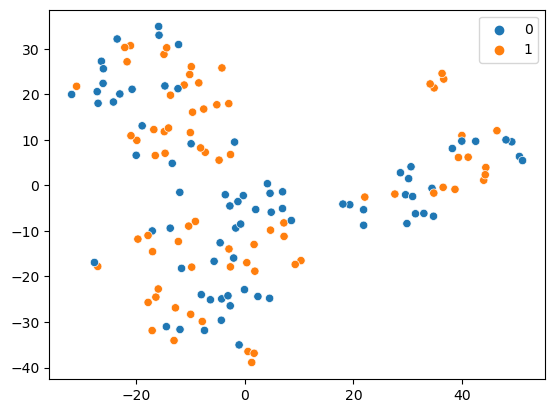

In [291]:
plt_tsne(X_norm, y_d)

The code beneath was not used

In [292]:
# plt_lda(X_norm, y_d)

# Feature selection


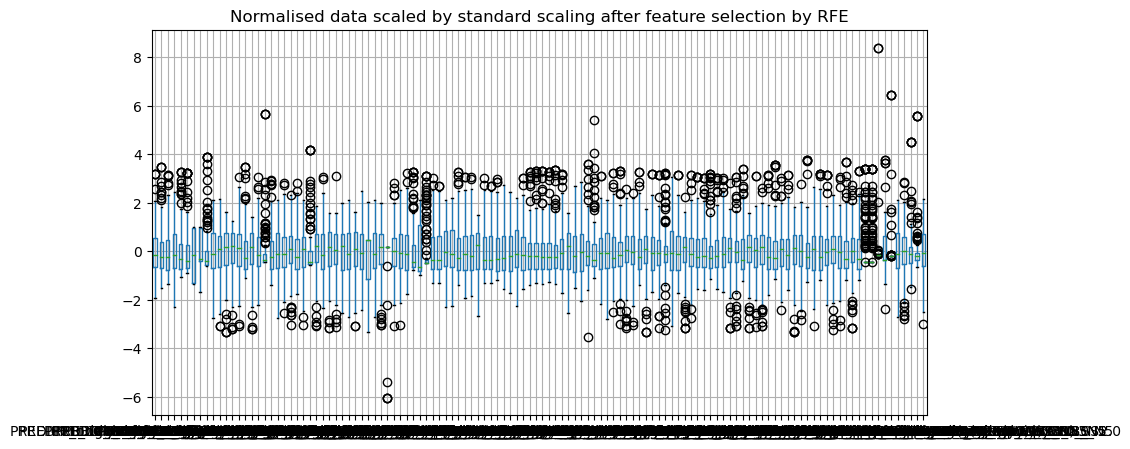

In [293]:
# Uncomment this to plot the ROC curves which shows the amount of features is nessesary to select to get a good performance

# n_original = X_norm.shape[1]
# feature_sizes = [10, 40, 115, n_original]
# le = LabelEncoder()
# y_d_bin = le.fit_transform(y_d.to_numpy().reshape(-1,))

# classifiers = [LDA(), RandomForestClassifier(), SVC(probability=True)]
# titles = ['LDA', 'RF', 'SVC']
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)

# for i, clf in enumerate(classifiers):
#     axs[i].set_xlabel('False Positive Rate')
#     axs[i].set_ylabel('True Positive Rate')
#     axs[i].set_title('ROC Curve {}'.format(titles[i]))
#     for size in feature_sizes:
#         model = LogisticRegression(max_iter=1000)
#         rfe = RFE(estimator=model, n_features_to_select=size)
#         rfe.fit(X_norm, y_d.to_numpy().reshape(-1,))
#         selected_features = X_norm.columns[rfe.support_]
#         X_tr_norm_selected = X_norm.loc[:, selected_features]
#         clf.fit(X_tr_norm_selected, y_d.to_numpy().reshape(-1,))
#         y_score_selected = clf.predict_proba(X_tr_norm_selected)
#         fpr_selected,tpr_selected,thesholds_selected = roc_curve(y_d_bin, y_score_selected[:, 1])
#         n_selected = X_tr_norm_selected.shape[1]
#         axs[i].plot(fpr_selected, tpr_selected, label=f'Selected {n_selected} from {n_original} features.')

# plt.legend(loc='lower right')
# plt.show()

final_X_norm, final_features = feature_selection(X_norm, y_d)

final_X_norm.boxplot(figsize=(10,5))
plt.title('Normalised data scaled by standard scaling after feature selection by RFE')
plt.show()

## Feature Extraction 
Principal Component Analisys (PCA) is used to reduce the dimensions of this complex problem. It uses the current features to recreate new "features" also called components. These components are each constructed with a combination of the current features.

To determine how many components will be created, it is necessary to get some insight in the data.

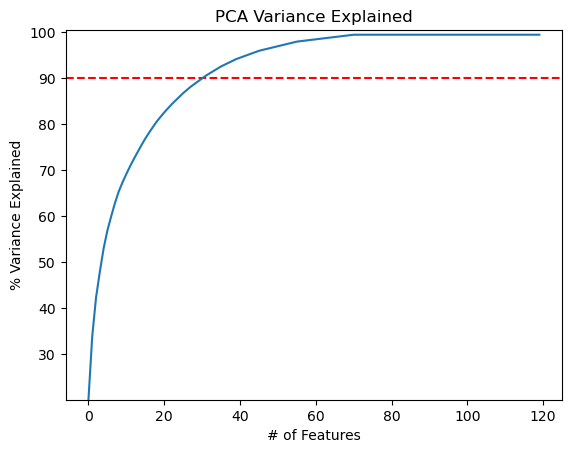

The index of the first number that is bigger than 90% is: 31


In [294]:
# To get info about whole dataset in PCA
variance1, var1 = PCA_variance(final_X_norm, final_features)
n_comp = PCA_amount_features(var1)

As is shown above, from index 31 on, the features are sufficient to retrieve above 90% of the variance within the datasets. Therefore it is chosen to perform a PCA analysis with the number of 32 components. A new dataset will be created with 32 components, that are based on the old 120 important features that were retrieved in the features selection.

In [295]:
# To get the new X_pca dataset
pca, X_pca, variance, var = PCA_transform(final_X_norm, n_comp)
df_explained_variance, mean_explained_variance, idx = PCA_transform_overview(variance, var)
# print(df_explained_variance.shape)
# scree_plot(df_explained_variance, mean_explained_variance, idx) #can be done for every component, now only component 1
# factor_loadings(X_tr_norm_selected, pca, df_explained_variance) #heatmap should be improved after better features selection 

PCA Overview
Total: 32 components
----------------------------------------
Mean explained variance: 0.028
----------------------------------------
    explained variance  cumulative [%]
1             0.200752            20.1
2             0.138207            33.9
3             0.083634            42.3
4             0.056133            47.9
5             0.051277            53.0
6             0.039070            56.9
7             0.030590            60.0
8             0.028627            62.9
9             0.024927            65.4
10            0.020180            67.4
11            0.017988            69.2
12            0.016973            70.9
13            0.016405            72.5
14            0.015217            74.0
15            0.014555            75.5
16            0.013840            76.9
17            0.013374            78.2
18            0.012155            79.4
19            0.011631            80.6
20            0.010460            81.6
21            0.010077            

The heatmap above shows for every new component which features are used to create this new component.
NOTE: get this more insightful; how?

## Classifier

It is time to find a model that can make predictions whether a tumor is benign or malign.
There are a lot of different ways of classifying. However we have only so much time and not every classifier makes sense. Three classifiers are chosen: RF, SVM and LDA. From this classifiers the hyperparameters are tuned by a 5-fold crossvalidation. Afther that the ensemble of this three is made. The performance of this four classifiers is evaluated and one final classifier is selected based on this performance.

In [296]:
def RF(X_train, X_test, y_train, y_test, n_iter=30):
    best_f1_RF = 0
    best_params_RF = {}
    f1_scores_rf = []
    param_dist = {
        'n_estimators': randint(5,70),
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    }

    for i in range(n_iter):
        rf = RandomForestClassifier(random_state=i)
        rs = RandomizedSearchCV(
            rf,
            param_distributions=param_dist,
            cv=5,  # Performing inner cross-validation!!!
            n_jobs=-1
        )

        rs.fit(X_train, y_train)
        best_rf = rs.best_estimator_
        y_pred = best_rf.predict(X_test)

        F1 = metrics.f1_score(y_test, y_pred)
        f1_scores_rf.append(F1)

        if F1 > best_f1_RF:
            best_f1_RF = F1
            best_params_RF = rs.best_params_

    print('Best hyperparameters:', best_params_RF)
    print('Best F1 score:', best_f1_RF)
    return best_params_RF, best_f1_RF

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_d_bin, test_size=0.2, random_state=42)

best_params_RF, best_f1_RF = RF(X_train, X_test, y_train, y_test)

RF_best_class = RandomForestClassifier(**best_params_RF)
scores_rf = cross_val_score(RF_best_class, X_pca, y_d_bin, cv=10, scoring='f1_macro')                   # Performing outer cross-validation!!!
print("Random forrest plot: the cross validation has a F1-score of %0.2f with a standard deviation of %0.2f" % (scores_rf.mean(), scores_rf.std()))

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 58}
Best F1 score: 0.9166666666666666
Random forrest plot: the cross validation has a F1-score of 0.80 with a standard deviation of 0.06


### After several runs: 
Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 20}\
Best F1 score: 0.9600000000000001\
Random forrest plot: the cross validation has a F1-score of 0.81 with a standard deviation of 0.10

In [297]:
def svm(X_train, X_test, y_train, y_test, n_iter=50):
    best_f1_svm = 0
    best_params_svm = {}
    f1_scores_svm = []
    param_dist_svm = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
    }

    for i in range(n_iter):
        svm = SVC(random_state=i)
        rs_svm = RandomizedSearchCV(
            svm,
            param_distributions=param_dist_svm,
            cv=5, # Performing inner cross-validation!!!
            n_jobs=-1
        )

        rs_svm.fit(X_train, y_train)
        best_svm = rs_svm.best_estimator_
        y_pred_svm = best_svm.predict(X_test)

        F1_svm = metrics.f1_score(y_test, y_pred_svm)
        f1_scores_svm.append(F1_svm)

        if F1_svm > best_f1_svm:
            best_f1_svm = F1_svm
            best_params_svm = rs_svm.best_params_

    print('Best hyperparameters:', best_params_svm)
    print('Best F1 score:', best_f1_svm)
    return best_params_svm, best_f1_svm

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_d_bin, test_size=0.2, random_state=42)
best_params_svm, best_f1_svm = svm(X_train, X_test, y_train, y_test)

svm_best_class = SVC(**best_params_svm)
scores_svm = cross_val_score(svm_best_class, X_pca, y_d_bin, cv=10, scoring='f1_macro')                                         # Performing outer cross-validation!!!
print("Support Vector Machine: the cross validation has a F1-score of %0.2f with a standard deviation of %0.2f" % (scores_svm.mean(), scores_svm.std()))

Best hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'C': 10}
Best F1 score: 0.888888888888889
Support Vector Machine: the cross validation has a F1-score of 0.88 with a standard deviation of 0.12


### Selected hyperparameters for SVM as input ensembling classifier in final model
Best hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'C': 10}\
Best F1 score: 0.888888888888889\
Support Vector Machine: the cross validation has a F1-score of 0.88 with a standard deviation of 0.12

In [298]:
def lda(X_train, X_test, y_train, y_test, n_iter=6):
    best_f1_lda = 0
    best_params_lda = {}
    f1_scores_lda = []
    n_classes = len(np.unique(y_train))
    param_dist_lda = {
        'store_covariance': [True, False],
        'solver': ['svd', 'lsqr', 'eigen'],
        'priors': [None] + [list(np.random.dirichlet(np.ones(n_classes))) for i in range(10)],
    }

    for i in range(n_iter):
        lda = LinearDiscriminantAnalysis()
        rs_lda = RandomizedSearchCV(
            lda,
            param_distributions=param_dist_lda,
            cv=5,  # Performing inner cross-validation!!!
            n_jobs=-1,
            random_state=i
        )

        rs_lda.fit(X_train, y_train)
        best_lda = rs_lda.best_estimator_
        y_pred_lda = best_lda.predict(X_test)

        F1_lda = metrics.f1_score(y_test, y_pred_lda)
        f1_scores_lda.append(F1_lda)

        if F1_lda > best_f1_lda:
            best_f1_lda = F1_lda
            best_params_lda = rs_lda.best_params_

    print('Best hyperparameters:', best_params_lda)
    print('Best F1 score:', best_f1_lda)
    return best_params_lda, best_f1_lda

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_d_bin, test_size=0.2, random_state=42)
best_params_lda, best_f1_lda = lda(X_train, X_test, y_train, y_test)


lda_best_class = LinearDiscriminantAnalysis(**best_params_lda)
scores_lda = cross_val_score(lda_best_class, X_pca, y_d_bin, cv=10, scoring='f1_macro')                             # Performing outer cross-validation!!!
print("Linear Discriminant Analysis: the cross validation has a F1-score of %0.2f with a standard deviation of %0.2f" % (scores_lda.mean(), scores_lda.std()))

Best hyperparameters: {'store_covariance': True, 'solver': 'svd', 'priors': [0.7502339588581852, 0.2497660411418148]}
Best F1 score: 0.8799999999999999
Linear Discriminant Analysis: the cross validation has a F1-score of 0.88 with a standard deviation of 0.14


### Selected hyperparameters for LDA as input ensembling classifier in final model
Best hyperparameters: {'store_covariance': True, 'solver': 'eigen', 'priors': [0.5287484663893824, 0.4712515336106177]}\
Best F1 score: 0.7857142857142856\
Linear Discriminant Analysis: the cross validation has a F1-score of 0.91 with a standard deviation of 0.14

## Ensembling
Next ensemble will be used to look if the several classifiers can compromise for each weaknesses and then in the end get a better result. Ensembling is a whole topic on its own, and therefore it is choosen to only do one ensemble. The three classifiers with the best hyperparameters will be used to create one classifiers that uses them all. By cross validation this new classifier will be compared to each one on its own.

In [299]:
# Create an ensemble of bagged classifiers
svm_bag = BaggingClassifier(estimator=svm_best_class, n_estimators=10, random_state=42)
lda_bag = BaggingClassifier(estimator=lda_best_class, n_estimators=10, random_state=42)
rf_bag = BaggingClassifier(estimator=RF_best_class, n_estimators=10, random_state=42)

ensemble = VotingClassifier(estimators=[('svm', svm_bag), ('lda', lda_bag), ('rf', rf_bag)], voting='hard')

scores_ensemble = cross_val_score(ensemble, X_pca, y_d_bin, cv=10, scoring='f1_macro')          

# Print the mean and standard deviation of the F1 scores
print("Ensemble: the cross-validation has a mean F1 score of %0.2f with a standard deviation of %0.2f" % (scores_ensemble.mean(), scores_ensemble.std()))

# Define the range of training set sizes to generate the learning curves
train_sizes = np.linspace(0.1, 1.0, 10)

# Set the common parameters for the learning curve plots
common_params = {
    'X': X_pca,
    'y': y_d_bin,
    'train_sizes': train_sizes,
    'cv': 10,
    'scoring': 'f1_macro',
    'random_state': 42,
    'n_jobs': -1
}

Ensemble: the cross-validation has a mean F1 score of 0.91 with a standard deviation of 0.09


# Chosen classifier
The ensemble showed the best results on classifing our train-validation data, therefor this classifier is further used in the pipeline. In this section the learningcurve is created to give an insight on the apparent and the true error to see if the classifier has enough complexity for the dataset.

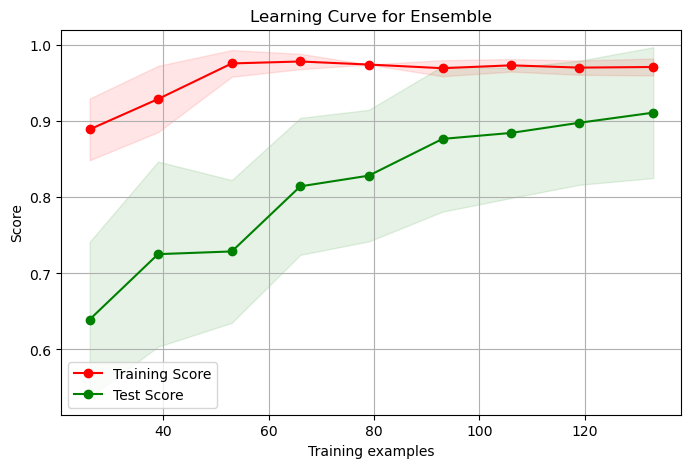

In [300]:
# Generate the learning curves for the ensemble
train_sizes, train_scores, test_scores = learning_curve(ensemble, **common_params)

# Plot the learning curves
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.set_title(f"Learning Curve for Ensemble")
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")
ax.grid()
ax.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1), np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color="r")
ax.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1), np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color="g")
ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training Score")
ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Test Score")
ax.legend(loc="best");

# Start pipeline

In [301]:
Ft_s = load_Ft_set()
D_s = load_D_set()

X_ft, y_ft, y_ft_bin = return_X_y(Ft_s)
X_d, y_d, y_d_bin = return_X_y(D_s)

le = LabelEncoder()
y_d_bin = le.fit_transform(y_d.to_numpy().reshape(-1,))
y_ft_bin = le.fit_transform(y_ft.to_numpy().reshape(-1,))

# Parameters needed: removed_features_preprocess, final_features, n_comp, **rf_hyperparams, **svm_hyperparams, **lda_hyperparams
X_filtered, removed_features_preprocess = preprocessing(X_d)
final_features

rf_hyperparams = {
    'max_depth': 20,
    'min_samples_leaf': 2,
    'min_samples_split': 6,
    'n_estimators': 20
}

svm_hyperparams = {
    'kernel': 'rbf',
    'gamma': 0.001,
    'C': 10
}

lda_hyperparams = {
    'store_covariance': False,
    'solver': 'svd',
    'priors': [0.6231810575673354, 0.3768189424326645]
}


def get_classification_metrics(y_true, y_pred_prob):
    # y_true: true labels of the test set
    # y_pred_prob: predicted probabilities of the positive class for the test set
    
    y_pred = y_pred_prob > 0.5  # Convert probabilities to binary predictions
    
    # Calculate recall, precision, f1-score for positive class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, pos_label=1, average='binary')
    
    # Calculate AUROC
    auroc = roc_auc_score(y_true, y_pred_prob)
    
    # Return as a dictionary
    return {'precision': precision, 'recall': recall, 'f1_score': f1_score, 'auroc': auroc}


def remove_features(X, removed_features_preprocess):
    # implementation of feature removal function
    return X.drop(columns=removed_features_preprocess)


def outliers(X):
    X_clean = X.copy()

    means = X.mean()
    stds = X.std()
    threshold = 3
    for feature in X.columns:

        # Calculate the lower and upper bounds for the feature
        lower_bound = means[feature] - (stds[feature] * threshold)
        upper_bound = means[feature] + (stds[feature] * threshold)

        # Replace outliers with upper and lower bound
        X_clean.loc[X_clean[feature] < lower_bound, feature] = lower_bound
        X_clean.loc[X_clean[feature] > upper_bound, feature] = upper_bound
    
    return X_clean


def normalize_standard(X_clean):
    # apply StandardScaler to each column of X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    # create a new DataFrame with scaled data
    X_normalized = pd.DataFrame(X_scaled, columns=X_clean.columns)

    return X_normalized


def selection_features(X_normalized, final_features):
    final_X_norm = X_normalized[final_features]
    return final_X_norm


svm_best_class = SVC(**svm_hyperparams)
lda_best_class = LinearDiscriminantAnalysis(**lda_hyperparams)
RF_best_class = RandomForestClassifier(**rf_hyperparams)

# create the bagging classifiers
svm_bag = BaggingClassifier(estimator=svm_best_class, n_estimators=10, random_state=42)
lda_bag = BaggingClassifier(estimator=lda_best_class, n_estimators=10, random_state=42)
rf_bag = BaggingClassifier(estimator=RF_best_class, n_estimators=10, random_state=42)

# create the ensemble classifier
ensemble = VotingClassifier(estimators=[('svm', svm_bag), ('lda', lda_bag), ('rf', rf_bag)], voting='hard')

# Define the pipeline
pipeline = Pipeline([
    ('remove_features', FunctionTransformer(remove_features, kw_args={'removed_features_preprocess': removed_features_preprocess})),
    ('outliers', FunctionTransformer(outliers)),
    ('normalize', FunctionTransformer(normalize_standard)),
    ('feature_selection', FunctionTransformer(selection_features, kw_args={'final_features': final_features})),
    ('pca', PCA(n_components=n_comp)),
    ('ensemble_fit', ensemble)
])

# Train the pipeline
pipeline.fit(X_d, y_d_bin)

# Predict using the pipeline
y_pred = pipeline.predict(X_ft)

get_classification_metrics(y_ft_bin, y_pred)


Number of removed columns due to zero-variance: 19
Number of removed non-zero-variance columns due to fraction zero > 80%: 11
Remaining number of features after preprocessing: 463


{'precision': 0.9375,
 'recall': 0.7142857142857143,
 'f1_score': 0.8108108108108109,
 'auroc': 0.8277310924369748}

# Conclusion
Using a pipeline and after the fit on the design set, it was managed to result in a F1-score of 81.1%. It showed our model is robust and generalises well. We think that due to the ensemble of the three classifiers with each having its own strenghts, the weaknesses of each classifier are probably overshadowed by the strengths of the others.

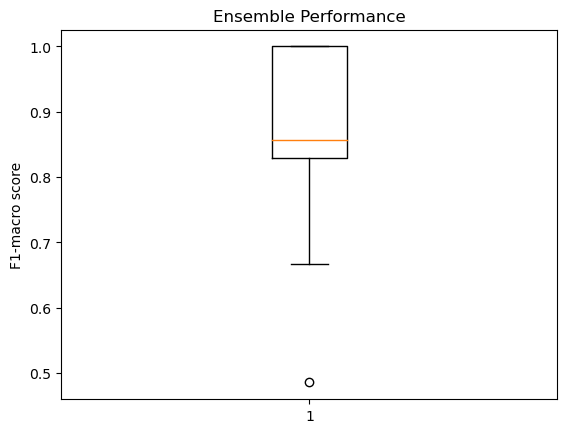

In [302]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

X_t1, y_t1, y_t1_bin = return_X_y(df)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)

# Perform cross-validation and get scores
scores = cross_val_score(pipeline, X_t1, y_t1_bin, cv=cv, scoring='f1_macro')

# Create boxplot of scores
fig, ax = plt.subplots()
ax.boxplot(scores)
ax.set_title('Ensemble Performance')
ax.set_ylabel('F1-macro score')
plt.show()